In [119]:
import fasttext
import umap
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from scipy.spatial.distance import cdist, cosine, euclidean
import tensorflow_hub as hub
from sklearn.decomposition import PCA, FastICA
from scipy.stats import ttest_ind, ttest_1samp
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans


In [120]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

In [121]:
# AUGMENTATION

In [122]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/harinisuresh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harinisuresh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
%matplotlib inline

In [52]:
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")

In [53]:
aug2 = naw.SynonymAug(aug_src='wordnet')

In [54]:
text = "The quick brown fox jumps over the lazy dog"
augmented_text = aug.augment(text)
augmented_text_2 = aug2.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)
print(augmented_text_2)

Original:
The quick brown fox jumps over the lazy dog
Augmented Text:
- quick brown fox jumps over the running dog
The quick brown charles james fox jumps over the indolent dog


In [157]:
text = 'The quick brown fox jumped over the lazy dog'
back_translation_aug_de = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)
back_translation_aug_ru = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-ru', 
    to_model_name='facebook/wmt19-ru-en'
)
back_translation_aug_ru.augment(text)
back_translation_aug_de.augment(text)

/Users/harinisuresh/.virtualenvs/test_cases/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


'The speedy brown fox leapt over the lazy dog'

In [49]:
back_translation_aug_ru.augment(text, n=3)

['Fast brown fox leaps over lazy dog',
 'Fast brown fox leaps over lazy dog',
 'Fast brown fox leaps over lazy dog']

In [ ]:
# MODELS

In [6]:
DATA_FPATH = 'data/reddit/'
MODEL_FPATH = 'models/reddit/'

In [7]:
subreddits = ['askscience', 'conspiracy', 'funny', 'hillaryclinton', 'history']

In [8]:
def check_valid_text(comment_text):
    bot_terms = ["I'm a bot", "I am a bot"]
    no_text_terms = ["[removed]", "[deleted]"]
    
    for t in bot_terms + no_text_terms: 
        if t in comment_text:
            return False
    return True

def write_fasttext_file(data, labels, fname):
    label_text = ['negative' if l == 0 else 'positive' for l in labels]
    with open(DATA_FPATH + fname, 'w') as f:
        for i,comment in enumerate(data):
            f.write('__label__%s %s' % (label_text[i], comment.replace('\n', ' ') + '\n'))
            
def get_train_test_dfs(df):
    fractions = np.array([0.75, 0.25])

    # shuffle input
    df = df.sample(frac=1, random_state=0) 

    # split into 2 parts
    train, test = np.array_split(
        df, (fractions[:-1].cumsum() * len(df)).astype(int))
    
    return train, test

def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))
    
def get_f1(p, r):
    return (2*p*r)/(p+r)

In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def find_nearest_arr(all_vecs, vec):
    dist = cdist(vec, all_vecs, 'cosine')
    idx = dist.argmin()
    return idx

## Load Comments

In [10]:
# Load Moderated comments
moderated_comments = pd.read_csv('data/reddit/reddit-removal-log.csv')
moderated_comments = moderated_comments[moderated_comments.subreddit.isin(subreddits)]
moderated_comments['moderated'] = 1

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [428]:
# Load Unmoderated comments
unmoderated_comments = []
for s in subreddits:
    for idx in range(201):
        with open("data/reddit/" + s + "/" + str(idx) + ".data", "r") as f:
            comment_obj = json.load(f)["data"]
            comment_list = [(item["body"], s, 0) for item in comment_obj if item["author"] != "AutoModerator"]
            unmoderated_comments.extend(comment_list)
unmoderated_comments = pd.DataFrame(unmoderated_comments, columns=["body", "subreddit", "moderated"])

In [429]:
# Combine
all_comments = pd.concat([moderated_comments, unmoderated_comments], ignore_index=True)
all_comments = all_comments[all_comments.body.apply(check_valid_text)]
all_comments.groupby(['subreddit', 'moderated']).size()

subreddit       moderated
askscience      0             9210
                1            13728
conspiracy      0            18495
                1             7871
funny           0            18126
                1            16221
hillaryclinton  0            16907
                1            39652
history         0            14719
                1            13425
dtype: int64

In [430]:
all_comments = all_comments.drop_duplicates(subset="body")

In [379]:
all_comments.to_csv('data/all_comments_df')

In [123]:
all_comments = pd.read_csv('data/all_comments_df')

In [124]:
embed = hub.load("/Users/harinisuresh/Dev/tf_hub/universal-sentence-encoder_4/")

In [125]:
sub = 'funny'

In [126]:
subreddit_comments = all_comments[all_comments.subreddit == sub].body.values

In [127]:
subreddit_labels = all_comments[all_comments.subreddit == sub].moderated.values

In [128]:
vecs = np.array(embed(subreddit_comments))

In [129]:
model = fasttext.load_model(MODEL_FPATH + "%s_model.bin" % sub)

In [18]:
def getModelPredsHelper(allExamples, model):
    exampleList = [x.replace('\n', ' ') for x in allExamples]
    preds = model.predict(exampleList)
    preds_int = np.array([1 if 'positive' in p[0] else 0 for p in preds[0]])
    preds_prob = np.array([p[0] for p in preds[1]])
    probs = np.array([1 - p if preds_int[i] == 0 else p for (i,p) in enumerate(preds_prob)])
    probs = [np.round(p,3) for p in probs]
    return probs

In [150]:
query = "retard"

In [151]:
matches = np.array([[i,c] for (i,c) in enumerate(subreddit_comments) if query.lower() in c.lower()])

In [152]:
matched_vecs = vecs[matches[:,0].astype(int)]
matched_sentences = matches[:,1]

In [117]:
# pd.DataFrame(
#     {"sentence": [m.replace('\n', ' ') for m in matches[:,1]]}
# ).to_csv("sentences.tsv", index=False, header=False, sep="\t")

In [118]:
# np.savetxt (
#     "vecs.tsv", matched_vecs, 
#     delimiter = "\t")
# np.savetxt (
#     "sentences.tsv", [m.replace('\n', ' ') for m in matches[:,1]], 
#     delimiter = "\t")

In [134]:
top_vec_idx = getKNNFromVector([np.mean(matched_vecs, axis=0)], vecs, subreddit_comments, n=50, return_idx=True)
knn_vecs = vecs[top_vec_idx]
sentences = subreddit_comments[top_vec_idx]

In [111]:
selected_arr = ['selected' if s in matched_sentences else 'not-selected' for s in sentences]

In [153]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(matched_vecs)

In [187]:
vecs[np.where(kmeans.labels_ == 0)[0]].shape

(79, 512)

In [154]:
for cluster in [0,1,2]:
    cluster_sentences = matched_sentences[np.where(kmeans.labels_ == cluster)]
    distance_to_center = cdist(
        [kmeans.cluster_centers_[cluster]], 
         matched_vecs[np.where(kmeans.labels_ == cluster)])[0]
    idx = np.argsort(distance_to_center)
    print('===================== CLUSTER %i =========================' % cluster)
    for i in idx[:5]: 
        print(cluster_sentences[i], end='\n------------------------\n')
    print("\n\n")

===================== CLUSTER 0 =========================
You're a retard
------------------------
Fuck you for being retarded.
------------------------
Holy shit you're actually retarded
------------------------
youre a fucking retard
------------------------
Are you fucking retarded?
------------------------



===================== CLUSTER 1 =========================
If your mom retarded? Pretty sure she's retarded.
------------------------
Oh.  Sorry that your kid is retarded.
------------------------
That's retarded. You're retarded. You're going to die alone.
------------------------
Well, you're retarded, and she thinks you're both losers.
------------------------
Shes retarded.
------------------------



===================== CLUSTER 2 =========================
You really do have mental tunnel vision eh?  Like a retarded pitbull?  Ill bet that makes you a great propane jockey though....

[PROOF RIGHT BACK](https://imgur.com/a/XaJ14).

Its almost as if it is some sort of shadow

In [146]:
seed = "Jesus Christ Reddit has reached a new low laughing at people with disabilities now. Fucking Americans are so insensitive. Come to Australia and fight me."

In [147]:
top_vec_idx = getKNNFromVector(embed([seed]), vecs, subreddit_comments, n=50, return_idx=True)
knn_vecs = vecs[top_vec_idx]
sentences = subreddit_comments[top_vec_idx]

In [148]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(knn_vecs)

In [149]:
for cluster in [0,1,2]:
    cluster_sentences = sentences[np.where(kmeans.labels_ == cluster)]
    
    print('===================== CLUSTER %i =========================' % cluster)
    for c in cluster_sentences:
        print(c, end='\n------------------------\n')
    print("\n\n")

===================== CLUSTER 0 =========================
I would have died laughing seeing this shit in person. This is what is wrong with America. 
------------------------
It's America, of course they're going to make a big deal about it, their country is filled with overly loud obnoxious retards.
------------------------
Was using America since most of the people in these comments are American 
------------------------
There's a lot wrong with our country these days, it's nice to be reminded that there's still so much great about it.
------------------------
Good job this is America where butthurt little racists can't control what you say or think.
------------------------



===================== CLUSTER 1 =========================
How am I a troll? Because I have downvotes? These people are morons and can't understand that not everyone hates her. She's a good comedian and makes me laugh, who the fuck are you people to tell me otherwise? 
------------------------
I'm sorry - did t

In [159]:
subreddit_comments

array(['You can tell this is fake because it shows a black father in the picture ',
       'The fat lady is singing.',
       'Good thing volks never break down. XD Shitty krout engineering ',
       ..., 'love the honesty\n',
       'At least an effort was made to obey the rules. Still killed a man though.',
       "Why?\n\nYou're young and can keep up with them.  You can relate with them more.  \n\nRisk of birth defects is far lower with younger parents as well (Everything from Autism to Down's syndrome.) Plus much easier recovery for younger mothers.\n\nThere's no better life motivation than to have kids. It's much easier to find a reason to get up and go to work when you've got 3 extra mouths to feed.  You find yourself gunning harder for promotions and working harder.  I'm a better employee now than I ever was pre-kids.  \n\nAnd I've left out the best part: Kids will be out of the house by our late 30s, and then we've got the rest of our lives to enjoy. While our peers are just no

In [183]:
comment_list = ['hi', 'ok', 'hello']

np.where(
    np.array([c not in comment_list for c in subreddit_comments])==False)

(array([441]),)

In [169]:
np.where(subreddit_comments == "ok")

(array([441]),)

In [172]:
subreddit_comments[441] in comment_list

True

In [68]:
np.argsort(
    cdist([kmeans.cluster_centers_[0]], 
    matched_vecs[np.where(kmeans.labels_ == 0)])[0])

array([ 0,  3, 12,  2,  1,  6,  5,  7,  9, 11,  4,  8, 10])

In [155]:
# example_list = [
#     "the country has to import rubbish from other countries",
#     "Not as low as any other country you ignorant moron.",
#     "Which country is this from? Do you like hambeasts or stupid people?",
#     "Except shes to stupid to not let savages in her country.",
#     "It's so funny how Asians, even from the dirtiest and shittiest countries, still have superiority complexes towards people from the 1st world.",
#     "Good job this is America where butthurt little racists can't control what you say or think.",
#     "You know, you are a fucking pathetic loser, making fun of other, superior, cultures like this. Fucking shameful - your ancestors would be ashamed - oh wait they were probably living in a shithole until korea saved their pathetic asses",
#     "I've nevER been triggered in my life. I just think my country would be better off without cunts like you."]


# hostile comments
example_list = ["Dude, I hate to break it to you, but I think you misread my original comment.",
                "So your commenting on how the terminology is slightly off? Fuck off",
                "When you comment like this, you sound like a fucking asshole. Just letting you know.",
                "Damn bro. I just triggered you, my bad. Pokefags are just silly."
                "stop commenting bullshit on my post. if you don't have anything useful to say, get off my post.....,",
                "You are clearly missing the point when you think you need to explain the obvious to me. Oh to be so privileged.",
                "LOOOOOL. You are so fucking stupid and you don't even know it. /r/iamverysmart",
                "You have no idea what you're talking about.",
                "You sound like a real piece of shit OP.",
                "Are you for real? Am I actually seeing this comment somewhat upvoted?",
                "'I know you are but what am I.' You quoted my entire post? Are you actually retarded?",
                "no offense, but youre kindof being an asshole. this whole thread including your posts is fucking filled with stupidity and assholeness",
                "I feel like you really missed an opportunity to type a comment that makes sense."]

# civilized comments
example_list_2 = [
    "i totally see where your coming from. i don’t think however that we should approach this with a gradient…",
    "I think we're going in a different direction here, but thank you for your contribution."
    "Yeah. That sounds right. Im just talking out of my ass to be honest. Cheers"
    "You are absolutely correct. I was thinking of reddit when I made my comment. I should've articulated that. Thank you for drawing my attention to my omission."
    "I'm aware, but thank you. I'm just saying, if you're going to correct one thing, it might as well be the worst error.",
    "Thats a clear idea on my side as well,,, nice said dear",
    "Thank you for saying this because I needed your comment to understand the joke here, I didn't see it at all.",
    "Oh, I think we're actually agreeing with each other then. I agree it must be hell, was just trying to say it's real nonetheless. Sorry for that misunderstanding!",
    "And here I was thinking this went the other way around; I guess I learned something new today.",
    "Aww man, I was going to make a similar, way less funny version of this joke. Thanks for getting to it first!"
]



# 

test_list = [
    "If your mom retarded? Pretty sure she's retarded."
]

In [158]:
for e in test_list: 
    print(e)
    print(back_translation_aug_ru.augment(e))
    print(back_translation_aug_de.augment(e))
    print("\n")

If your mom retarded? Pretty sure she's retarded.
If your mom is late? Pretty sure she's late.
If your mother is delayed? Pretty sure she is delayed.




In [16]:
def quantify_shift(shift_target, example_list, example_list_2, labels = None, labels_2 = None, list_names=["list 1", "list 2"]): 
    if shift_target == "predictions":
        preds_1 = getModelPredsHelper(example_list, model)
        preds_2 = getModelPredsHelper(example_list_2, model)
        ttest_result = ttest_ind(preds_1, preds_2)
        if ttest_result.pvalue >= 0.05: 
            print("Predictions are not significantly different.")
        else: 
            operator = "higher" if ttest_result.statistic > 0 else "lower"
            print("P(moderated) for %s is *%s* than for %s (pval = %.3f)" % (list_names[0], operator, list_names[1], ttest_result.pvalue))
            
            
    elif shift_target == "representation":
        vecs_1 = [model.get_sentence_vector(ex) for ex in example_list]
        vecs_2 = [model.get_sentence_vector(ex) for ex in example_list_2]
        intergroup_diffs = cdist(vecs_1, vecs_2).flatten()
        intragroup_diffs = np.concatenate((cdist(vecs_1, vecs_1).flatten(), cdist(vecs_2, vecs_2).flatten()))
        ttest_result = ttest_ind(intergroup_diffs, intragroup_diffs)
        if ttest_result.statistic > 0 and ttest_result.pvalue < 0.05: 
            print("Representations for %s are significantly different from %s (pval = %f)." % (list_names[0], list_names[1], ttest_result.pvalue))
        else: 
            print("Representations for %s and %s are not significantly different." % (list_names[0], list_names[1]))
            
            
    elif shift_target == "performance":
        preds_1 = getModelPredsHelper(example_list, model)
        preds_2 = getModelPredsHelper(example_list_2, model)
        perf_1 = np.array([np.round(preds_1[i]) == labels[i] for i in range(len(preds_1))]).astype(int)
        perf_2 = np.array([np.round(preds_2[i]) == labels_2[i] for i in range(len(preds_2))]).astype(int)
        ttest_result = ttest_ind(perf_1, perf_2)
        if ttest_result.pvalue >= 0.05: 
            print("Model performance on %s and %s is not significantly different." % (list_names[0], list_names[1]))
        else: 
            operator = "higher" if ttest_result.statistic > 0 else "lower"
            print("Model performance on %s is *%s* than for %s (pval = %.3f)" % (list_names[0], operator, list_names[1], ttest_result.pvalue))
          
        

In [17]:
quantify_shift("representation", example_list, example_list_2, list_names = ["'Hostile'", "'Civil Disagreement'"])

Representations for 'Hostile' are significantly different from 'Civil Disagreement' (pval = 0.000003).


In [18]:
quantify_shift("performance", example_list, example_list_2, labels = np.ones(len(example_list)), labels_2 = np.zeros(len(example_list_2)), list_names = ["'Hostile'", "'Civil Disagreement'"])

Model performance on 'Hostile' and 'Civil Disagreement' is not significantly different.


In [19]:
quantify_shift("predictions", example_list, example_list_2, list_names = ["'Hostile'", "'Civil Disagreement'"])

P(moderated) for 'Hostile' is *higher* than for 'Civil Disagreement' (pval = 0.013)


In [20]:
preds_1 = getModelPredsHelper(example_list, model)
preds_2 = getModelPredsHelper(example_list_2, model)

In [38]:
pd.DataFrame(
    {"sentence": example_list + example_list_2, 
     "example_set": [0]*len(example_list) + [1]*len(example_list_2)}
).to_csv("sentences.tsv", index=False, sep="\t")

7

In [32]:
np.savetxt (
    "vecs.tsv",
    np.concatenate((
        embed(example_list),
        embed(example_list_2)
    )), 
    delimiter = "\t")

(array([1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.019  , 0.02868, 0.03836, 0.04804, 0.05772, 0.0674 , 0.07708,
        0.08676, 0.09644, 0.10612, 0.1158 , 0.12548, 0.13516, 0.14484,
        0.15452, 0.1642 , 0.17388, 0.18356, 0.19324, 0.20292, 0.2126 ,
        0.22228, 0.23196, 0.24164, 0.25132, 0.261  , 0.27068, 0.28036,
        0.29004, 0.29972, 0.3094 , 0.31908, 0.32876, 0.33844, 0.34812,
        0.3578 , 0.36748, 0.37716, 0.38684, 0.39652, 0.4062 , 0.41588,
        0.42556, 0.43524, 0.44492, 0.4546 , 0.46428, 0.47396, 0.48364,
        0.49332, 0.503  , 0.51268, 0.52236, 0.53204, 

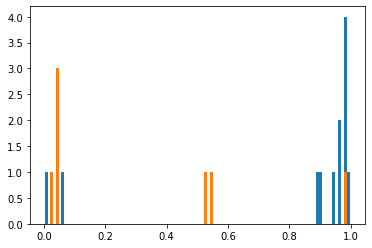

In [204]:
plt.hist(preds_1,bins=100)
plt.hist(preds_2,bins=100)

In [60]:
preds = np.concatenate((
    preds_1, preds_2))

examples = np.concatenate((example_list, example_list_2))

In [71]:
examples[np.where((preds < 0.95) & (preds > 0.8))]

array(['So your commenting on how the terminology is slightly off? Fuck off',
       'You are clearly missing the point when you think you need to explain the obvious to me. Oh to be so privileged.',
       'no offense, but youre kindof being an asshole. this whole thread including your posts is fucking filled with stupidity and assholeness'],
      dtype='<U436')

In [146]:
example_list_vecs = np.array([model.get_sentence_vector(ex) for ex in example_list])

In [147]:
example_list_2_vecs = np.array([model.get_sentence_vector(ex) for ex in example_list_2])

In [148]:
example_vecs = np.concatenate((example_list_vecs, example_list_2_vecs))
examples = example_list + example_list_2
colors = ["blue"]*len(example_list) + ["red"]*len(example_list_2)

In [149]:
v = np.mean(example_list_2_vecs,axis=0) - np.mean(example_list_vecs,axis=0)
v_norm = np.sqrt(sum(dir_vec**2))    

In [150]:
proj_of_examples_on_dir = [(np.dot(u, v)/v_norm**2)*v for u in example_vecs]

In [151]:
def mag(v):
    return np.sqrt(sum([el**2 for el in v]))

projection_mags = [mag(proj) for proj in proj_of_examples_on_dir]

In [152]:
np.array(examples)[np.argsort(projection_mags)]

array(['i totally see where your coming from. i don’t think however that we should approach this with a gradient…',
       'And here I was thinking this went the other way around; I guess I learned something new today.',
       'You are clearly missing the point when you think you need to explain the obvious to me. Oh to be so privileged.',
       'So your commenting on how the terminology is slightly off? Fuck off',
       'I feel like you really missed an opportunity to type a comment that makes sense.',
       'no offense, but youre kindof being an asshole. this whole thread including your posts is fucking filled with stupidity and assholeness',
       "Thank you for saying this because I needed your comment to understand the joke here, I didn't see it at all.",
       "Oh, I think we're actually agreeing with each other then. I agree it must be hell, was just trying to say it's real nonetheless. Sorry for that misunderstanding!",
       'Aww man, I was going to make a similar, way 

Text(0.5, 1.0, 'projection onto vector from example set 1 --> example set 2')

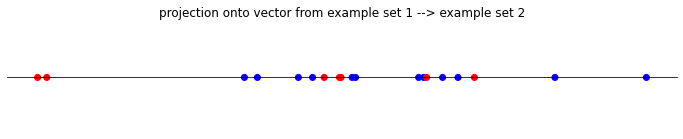

In [163]:
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('center')
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.scatter(projection_mags, y=[0]*len(projection_mags), c=colors)
plt.title("projection onto vector from example set 1 --> example set 2")

In [80]:
start = np.mean(example_list_vecs,axis=0)
end = np.mean(example_list_2_vecs,axis=0)

In [88]:
intermediate_vecs = []
for i in range(30):
    new_vec = start + (dir_vec/10)*i
    intermediate_vecs.append(new_vec)
    idx = find_nearest_arr(example_vecs, [new_vec])
    print(examples[idx])

You sound like a real piece of shit OP.
You sound like a real piece of shit OP.
So your commenting on how the terminology is slightly off? Fuck off
So your commenting on how the terminology is slightly off? Fuck off
So your commenting on how the terminology is slightly off? Fuck off
And here I was thinking this went the other way around; I guess I learned something new today.
And here I was thinking this went the other way around; I guess I learned something new today.
i totally see where your coming from. i don’t think however that we should approach this with a gradient…
I feel like you really missed an opportunity to type a comment that makes sense.
I feel like you really missed an opportunity to type a comment that makes sense.
I feel like you really missed an opportunity to type a comment that makes sense.
You have no idea what you're talking about.
You have no idea what you're talking about.
Aww man, I was going to make a similar, way less funny version of this joke. Thanks for g

In [194]:
getModelPredsHelper(np.array(intermediate_vecs), model)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [146]:
labels = [0]*len(example_list_vecs) + [1]*len(example_list_2_vecs)

In [147]:
x = np.concatenate((example_list_vecs, example_list_2_vecs))

In [148]:
lr = LogisticRegression()
lr.fit(x, labels)

LogisticRegression()

In [150]:
lr.coef_.shape

(1, 512)

In [ ]:
z = lambda x,y: (-clf.intercept_[0] - clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]


In [116]:
toy_vecs_1 = np.array([
    [.2,.2],
    [.21,.21],
    [.23,.21],
    [.19,.2],
    [.18,.22],
    [.21, .19],
    [.22,.2],
    [.23,.21],
    [.16,.21],
    [.19,.22],
    [.18,.21],
    [.2, .19],
])


toy_vecs_2 = np.array(toy_vecs_1) + 0.6

In [136]:
labels = [0]*len(toy_vecs_1) + [1]*len(toy_vecs_2)

In [119]:
lr = LogisticRegression()

In [121]:
lr.fit(np.concatenate((toy_vecs_1, toy_vecs_2)), labels)

LogisticRegression()

In [129]:
# Retrieve the model parameters.
b = lr.intercept_[0]
w1, w2 = lr.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

In [131]:
xmin, xmax = 0, 1
xd = np.array([xmin, xmax])
yd = m*xd + c

In [143]:
lr.coef_

array([[1.81188914, 1.81456072]])

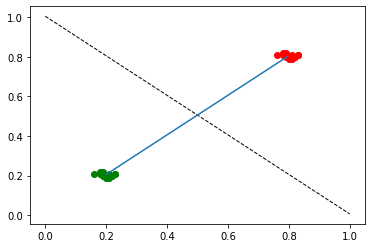

In [170]:
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.scatter(toy_vecs_1[:,0], toy_vecs_1[:,1], c='green')
plt.scatter(toy_vecs_2[:,0], toy_vecs_2[:,1], c='red')
plt.plot(xs,ys)

In [161]:
dir_vec = np.mean(toy_vecs_2,axis=0) - np.mean(toy_vecs_1,axis=0)
dir_vec[0]/100

array([0.006, 0.006])

In [167]:
start = np.mean(toy_vecs_1,axis=0)
end = np.mean(toy_vecs_2,axis=0)
xs = np.arange(start[0], end[0], dir_vec[0]/100)
ys = np.arange(start[1], end[1], dir_vec[1]/100)

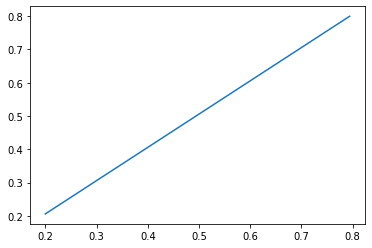

In [102]:
def getKNNFromVector(vec, all_vecs, comments, n=30, return_idx=False):
    dist_vec = cdist(vec, all_vecs, 'cosine')
    top_vec_idx = np.argsort(dist_vec[0])[1:n+1]
    if return_idx: return top_vec_idx
    top_comments = np.array(comments)[top_vec_idx]
    top_comments = [c for c in top_comments]
    return top_comments

In [53]:
vec = np.mean(example_list_vecs, axis=0)
all_vecs = np.array(vecs)

In [55]:
dist_vec = cdist([vec], all_vecs, 'cosine')

In [79]:
top_vec_idx = np.argsort(dist_vec[0])[:200]

In [81]:
top_vec_labels = subreddit_labels[top_vec_idx]

In [84]:
pos_vecs = all_vecs[top_vec_idx][np.where(top_vec_labels == 0)]
neg_vecs = all_vecs[top_vec_idx][np.where(top_vec_labels == 1)]

In [87]:
pos_pt = np.mean(pos_vecs, axis=0)
neg_pt = np.mean(neg_vecs, axis=0)

In [97]:
find_nearest_arr(all_vecs[top_vec_idx], [neg_pt])

21

In [98]:
subreddit_comments[top_vec_idx][21]

"You're a fucking idiot."

In [33]:
preds = getModelPredsHelper(subreddit_comments, model)

In [50]:
unmod_idx = np.where(np.array(subreddit_labels) == 0)

In [52]:
getKNNFromVector([vec], all_vecs[unmod_idx], subreddit_comments[unmod_idx], 30)

['I feel like you really missed an opportunity to type a comment that makes sense.  ',
 'Well, your comment got an upvote, so you have that going for you.',
 "That has nothing to do with anything so I know you're being down voted but that made me laugh so have an upvote",
 'You sound like a dick.',
 "Thank you for saying this because I needed your comment to understand the joke here, I didn't see it at all.",
 "I'm not sure what this has to do with your comment, but holy hell I love your user name",
 "Well, that's not actually something I said, or believe.  But OK.  Clearly I missed a joke here, not sure I deserve the snark.",
 "Sounds like you're not really tired of this argument. That was quite a rant.",
 "This was ages ago and your post was long. I'm sorry, you were right, I was wrong.",
 'Haha, I am genuinely sorry man. I am an asshole.',
 "Don't you know people on reddit don't know that you're being sarcastic unless you put /s?",
 "You have no idea what you're talking about. ",
 '

In [417]:
np.savetxt("embed.tsv", vecs, delimiter="\t")

In [420]:
pd.DataFrame({'comment': [x.replace('\n', ' ') for x in subreddit_comments], 'label': subreddit_labels}).to_csv("metadata.tsv", sep="\t")

In [ ]:
vecs.to_cs

In [386]:
model = fasttext.load_model(MODEL_FPATH + "%s_model.bin" % sub)

In [387]:
def getModelPredsHelper(allExamples, model):
    exampleList = [x.replace('\n', ' ') for x in allExamples]
    preds = model.predict(exampleList)
    preds_int = np.array([1 if 'positive' in p[0] else 0 for p in preds[0]])
    preds_prob = np.array([p[0] for p in preds[1]])
    probs = np.array([1 - p if preds_int[i] == 0 else p for (i,p) in enumerate(preds_prob)])
    probs = [np.round(p,3) for p in probs]
    return probs

In [388]:
preds = np.array(getModelPredsHelper(subreddit_comments, model))

In [389]:
np.save(DATA_FPATH + sub + '/preds.npy', preds)

In [341]:
pca = PCA(n_components=3)
pca_vecs = pca.fit_transform(vecs[idx])

In [348]:
dim = 2
pca_v = pca.transform(v)
val = pca_v[0][dim]

In [349]:
sorted_vecs_idx = np.argsort(pca_vecs[:,dim])
sorted_vecs = pca_vecs[:,dim][sorted_vecs_idx]
sorted_comments = subreddit_comments[idx][sorted_vecs_idx]
nearest_idx = find_nearest(sorted_vecs, val)

In [350]:
subreddit_comments[idx][nearest_idx-15:nearest_idx+15]

array(['thats really good', "That's fricking adorable.",
       'Well hope you two the best', "You're a twat. ", 'You just came',
       "Hey, I think I've been there!", 'You\'re real cute bitch."',
       "Holy shit you're a funny guy !", 'That made my day',
       "You're a hero ", 'You know just what we like 😏',
       'You are really genius.', "That's phenomenal!", "You're boring.",
       'I LIKE WHAT YOU GOT!', 'hey, its you, me', 'That is adorable. ',
       'Wow great ', 'Hahahahha nice', "It's beautiful",
       'It feels amazing.',
       'Dude you are so full of yourself seriously.. ',
       "You're a piece of shit", 'Wow amazing dude',
       "Stop being so nice when I'm obviously shitting on you. I can't handle such profound niceness!",
       "***YOU'RE A BITCH SOMETHING SOMETHING!***", 'nice', 'Nice',
       'Nice', 'nice'], dtype=object)

In [253]:
dim = 1
pca_v = pca.transform(v)
val = pca_v[0][dim]
diffs = [abs(val-x) for x in pca_vecs[:,dim]]

In [69]:
with open(DATA_FPATH + sub + '/comments', 'rb') as f:
    comments = f.readlines()

In [254]:
subreddit_comments[idx][np.argsort(diffs)][:30]

array(['I hate you. ', 'my left ear hates you.',
       'I hate you.  Well-played. ', 'I love you! ',
       "It wasn't me, I swear!",
       'I dont even know you but I do know that I hate you',
       'Fuck you OP', 'Hate "____ of the year" in god damn January',
       'you beat me to it', 'i will bite you', 'I love you, reddit.\n',
       'Fuck you', 'Fuck you. ', 'Fuck you.', 'Fuck you! ', 'Fuck you',
       'Fuck you', 'Fuck you', 'Fuck you', 'fuck you', 'Fuck you',
       'fuck you', 'Fuck you.', 'fuck you', 'Fuck you', 'Fuck you',
       'Fuck you! ', 'Fuck you.', 'Fuck you', 'Fuck you.'], dtype=object)

In [188]:
subreddit_comments[
    np.where((pca_vecs[:,dim] > val - 0.01) & (pca_vecs[:,dim] < val + 0.01))]

array(['The comment is accurate. Denial is cancer. ', "Where's the dad?",
       'Came here for Dickbutt, was disappointed. So here, [have some Dickbutt.](http://i.imgur.com/onecbf7.gifv)',
       'cunt', 'Whatever a good pose he made',
       'Now show me your titties!', 'Fuck the French!',
       'I wish I was high on potenuse', 'Solid South Park reference.',
       "She seems very talented!  That's the creepiest looking face I've ever seen.",
       'That final boop. ', 'attention whore',
       'is that zuckerberg on the right? :D',
       '[Word cloud out of all the comments.](http://i.imgur.com/yTzb59V.png)\n\nI hope you like it',
       '[Word cloud out of all the comments.](http://i.imgur.com/5PiN3SP.png)\n\nI hope you like it',
       "It's ok these crackers will never understand.",
       'You gotta get that [Candy Crush](https://youtu.be/u3ik6VeN8Fg)',
       'Nice', "He's not... that looks nothing like him you faggot",
       'She came all that way to lol at the great Satan

In [196]:
def getKNNFromVector(vec, n=30, return_idx=False):
    dist_vec = cdist(vec, vecs, 'cosine')
    top_vec_idx = np.argsort(dist_vec[0])[1:n+1]
    if return_idx: return top_vec_idx
    top_comments = np.array(comments)[top_vec_idx]
    top_comments = [c for c in top_comments]
    return top_comments

In [60]:
sentence = "You're so nice"
v = np.array(embed([sentence]))
v = np.mean(v, axis=0)

In [72]:
subreddit_comments 

array(['You can tell this is fake because it shows a black father in the picture ',
       'The fat lady is singing.',
       'Good thing volks never break down. XD Shitty krout engineering ',
       ..., 'love the honesty\n',
       'At least an effort was made to obey the rules. Still killed a man though.',
       "Why?\n\nYou're young and can keep up with them.  You can relate with them more.  \n\nRisk of birth defects is far lower with younger parents as well (Everything from Autism to Down's syndrome.) Plus much easier recovery for younger mothers.\n\nThere's no better life motivation than to have kids. It's much easier to find a reason to get up and go to work when you've got 3 extra mouths to feed.  You find yourself gunning harder for promotions and working harder.  I'm a better employee now than I ever was pre-kids.  \n\nAnd I've left out the best part: Kids will be out of the house by our late 30s, and then we've got the rest of our lives to enjoy. While our peers are just no

In [390]:
np.save(DATA_FPATH + sub + '/embs.npy', vecs)
np.save(DATA_FPATH + sub + '/comments.npy', subreddit_comments, allow_pickle=True)

In [393]:
np.save(DATA_FPATH + sub + '/labels.npy', subreddit_labels)

In [399]:
subreddit_labels[np.where(subreddit_comments == "I would hate-fuck you")]

array([1])

In [45]:
np.load(DATA_FPATH + sub + '/embs.npy')
with open(DATA_FPATH + sub + '/comments', 'rb') as f:
    comments_from_file = f.readlines()

In [49]:
comments_from_file[0].decode()

'You can tell this is fake because it shows a black father in the picture \n'

## Train Models

In [92]:
# Save data txt files
for s in subreddits: 
    subreddit_comments = all_comments[all_comments.subreddit == s]
    train, test = get_train_test_dfs(subreddit_comments)
    write_fasttext_file(train.body, train.moderated, '%s_train.txt' % s)
    write_fasttext_file(test.body, test.moderated, '%s_test.txt' % s)

In [93]:
# get subreddit models + eval them across subreddits
confusion_matrix = []
for train_s in subreddits: 
    subreddit_model = fasttext.train_supervised(
        DATA_FPATH + '%s_train.txt' % train_s, 
        lr = 0.05,
        wordNgrams = 3,
        epoch = 25,
        dim = 200)
    subreddit_model.save_model(MODEL_FPATH + "%s_model.bin" % train_s)
    
    conf_matrix_row = []
    for test_s in subreddits: 
        N, p, r = subreddit_model.test(DATA_FPATH + '%s_test.txt' % test_s)
        conf_matrix_row.append(get_f1(p,r))
        
    confusion_matrix.append(conf_matrix_row)

In [94]:
confusion_matrix = np.flip(np.array(confusion_matrix), axis=0)

## Cross-subreddit Evaluation

F1 Scores for Subreddit Moderation Models


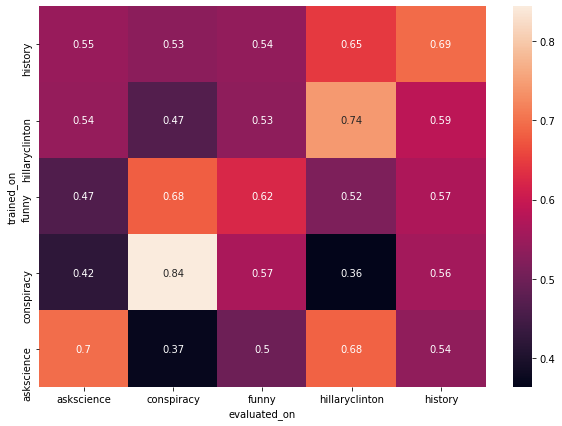

In [95]:
df_cm = pd.DataFrame(confusion_matrix, index = np.flip(subreddits),
                     columns = subreddits)
df_cm.index.name = 'trained_on'
df_cm.columns.name = 'evaluated_on'

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
print('F1 Scores for Subreddit Moderation Models');

## Analysis of correct vs incorrect predictions

In [102]:
pred_type_dict = {'tp': 0, 'tn': 1, 'fp': 2, 'fn': 3}
def get_error_type(pred, label):
    if label == 1 and pred == 0: 
        return 'fn'
    elif label == 1 and pred == 1:
        return 'tp'
    elif label == 0 and pred == 1:
        return 'fp'
    else: 
        return 'tn'

In [105]:
train_on = 'funny'
eval_on = 'funny'

In [106]:
# Get predictions on different subreddit
model = fasttext.load_model(MODEL_FPATH + "%s_model.bin" % train_on)
train, test = get_train_test_dfs(all_comments[all_comments.subreddit == eval_on])
test_str = [x.replace('\n', ' ') for x in test.body]
preds = model.predict(test_str)

In [107]:
preds

([['__label__negative'],
  ['__label__positive'],
  ['__label__positive'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__positive'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__positive'],
  ['__label__positive'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__negative'],
  ['__label__positive'],
  ['__label__negative'],
  ['__label__negative'],


In [108]:
# Predictions + Labels
preds_int = np.array([1 if 'positive' in p[0] else 0 for p in preds[0]])
labels = np.array(test.moderated.to_list())
preds_prob = np.array([p[0] for p in preds[1]])

In [109]:
# Classify mistakes
correct = preds_int == labels
pred_types = np.array([get_error_type(preds_int[i], labels[i]) for i in range(len(test))])
pred_types_int = np.array([pred_type_dict[p] for p in pred_types])

In [115]:
test_str

['In our house we call it Decembeard.. followed by Januhairy.',
 "riding top comment to say unfortunately the streamer rips off artists, does not give credit and hides under the guise of charity. Here's the blizzcon original. ",
 'I plane it',
 "I'd pay good money to see Bernie pick up and body slam Trump.",
 'How much is the small hallway restricting her from tackling with proper form?',
 "Hi DoctorDolphLundgren, your [post](https://www.reddit.com/r/funny/comments/4tc3f8/i_made_the_first_cut/) breaks [the rules](https://www.reddit.com/r/funny/wiki/rules) of /r/funny and has been removed for the following reason(s):  * No SMS or Social Media Content (including Reddit). [Read more here](https://www.reddit.com/r/funny/wiki/rules#wiki_14.\\_no\\_sms\\_or\\_social\\_media\\_content\\_.28including\\_reddit.29)    *If you feel this was done in error, or would like further clarification, please don't hesitate to [message the mods](https://www.reddit.com/message/compose?to=%2Fr%2Ffunny&message

In [14]:
# Sentence vectors
test_vecs = []
for s in test_str:
    test_vecs.append(model.get_sentence_vector(s))
test_vecs = np.array(test_vecs)
test_vecs_positive_pred = test_vecs[preds_int == 1]

In [15]:
# Reduce w UMAP
reducer = umap.UMAP(metric='cosine', n_neighbors=50, min_dist=0.25)
reducer.fit(test_vecs)
reduced_embeddings = reducer.transform(test_vecs)

KeyboardInterrupt: 

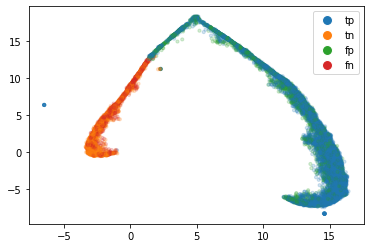

In [16]:
fig, ax = plt.subplots()
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    s = 10,
    alpha = 0.2,
    c=[sn.color_palette()[x] for x in pred_types_int])

circles = [Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=sn.color_palette()[x]) for x in range(4)]
ax.legend(circles, pred_type_dict.keys())

In [17]:
print("--- Correctly moderated: ---")
print(test.body.values[np.where(pred_types=='tp')])

print('\n\n')

print("--- Incorrectly moderated: ---")
print(test.body.values[np.where(pred_types=='fp')])

print('\n\n')

print("--- Correctly *un*moderated: ---")
print(test.body.values[np.where(pred_types=='tn')])

print('\n\n')

print("--- Incorrectly unmoderated (should have been moderated): ---")
print(test.body.values[np.where(pred_types=='fn')])

--- Correctly moderated: ---
['Wait whats going on in florida? i thought the polls have her up? Aw kaine just canceled his rally whats going on people? us 30 people were very dissapointed!'
 "Is this suppose to do something for me? It's an anti-establishment year. You'd be better served showing normal people."
 "Isn't that what the second amendment is for??" ...
 "You've been issued your first stump." 'change the subject dupe'
 'but where is the stuff about hillary']



--- Incorrectly moderated: ---
["Yeah I get that, happens all over Reddit and it's super easy to become jaded toward other groups with all the shit posting and trolling going on.\n\nWe were instantly at each others throats (although I admittedly made the first drunk pass), when I'm sure we'd be capable of having a rational, relatively civil discussion in real life, which is what this whole process is supposed to be all about anyway."
 'What do you think Obama would do in that situation? '
 'http://m.imgur.com/bcNjPtV?r\

In [44]:
uncertain_idx = np.where((preds_prob < 0.6) & (preds_prob > 0.4))[0]

In [48]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [49]:
kmeans.fit(test_vecs[uncertain_idx])
clusters = kmeans.predict(test_vecs[uncertain_idx])

In [52]:
print(test.body.values[uncertain_idx[np.where(clusters == 2)]])

['Madam Prisoner ' 'No' "That's better." 'Good news!! ' 'wrong.'
 'and BEEEEEEENGHAAAAAZIIIIII' 'July 20' 'At least.' 'Me irl' '!'
 "I'm depressed" 'No'
 'Yup. \n\nhttps://www.youtube.com/watch?v=dBaTVwIJH-E' 'not really...'
 '1 ET ' 'No']


In [18]:
kmeans = KMeans(n_clusters=5, random_state=0)

In [19]:
kmeans.fit(test_vecs)

KMeans(n_clusters=5, random_state=0)

In [20]:
clusters = kmeans.predict(test_vecs)

In [21]:
cluster_preds = pd.DataFrame({'cluster': clusters, 'pred_type': pred_types}).groupby(['cluster', 'pred_type']).size()

In [22]:
cluster_preds = pd.DataFrame(cluster_preds, columns=['count']).reset_index().pivot(index='cluster', columns='pred_type', values='count').fillna(0)

<AxesSubplot:xlabel='cluster'>

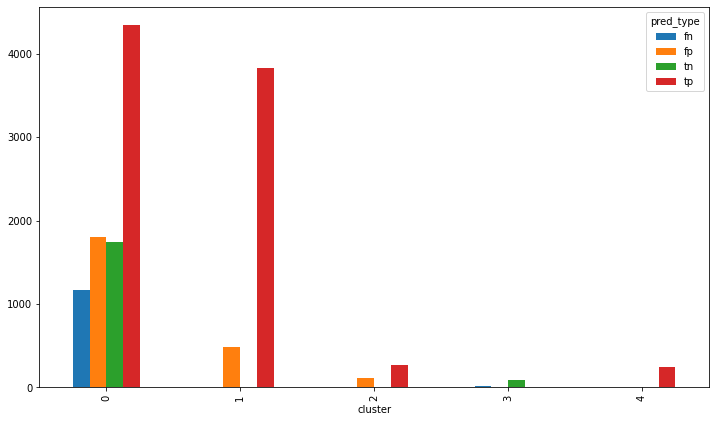

In [23]:
cluster_preds.plot.bar(figsize=(12,7))

In [480]:
for c in range(kmeans.n_clusters):
    print("CLUSTER %i" % c)
    print("num examples: %i" % len(np.where(clusters==c)[0]))
    print("--- Correctly moderated (TP): ---")
    print(test.body.values[np.where((clusters==c) & (pred_types == 'tp'))][:20])
    
    print('\n\n')
    
    print("--- Incorrectly moderated (FP): ---")
    print(test.body.values[np.where((clusters==c) & (pred_types == 'fp'))][:20])
    
    print('\n\n')
    
    print("--- Correctly *un*moderated (TN): ---")
    print(test.body.values[np.where((clusters==c) & (pred_types == 'tn'))][:20])
    
    print('\n\n')
    
    print("--- Incorrectly *un*moderated (FN): ---")
    print(test.body.values[np.where((clusters==c) & (pred_types == 'fn'))][:20])
    
    print('\n\n')

CLUSTER 0
num examples: 427
--- Correctly moderated (TP): ---
['m' 'j' 'lol' 'c' '#corruptionabovecountry' 'Both?' 'lol' 'h' 'lol'
 'http://ifunny.co/fun/lE9rocc34' 'http://youtu.be/Zr1IDQ2V1eM' 'Mods'
 'lol' '*here*\n\n\\#MakeAmericaSpellAgain!' 'TRUMP2016' 'Trump?' 'lol'
 'w' 'Alhamdillalah ' 'lol']



--- Incorrectly moderated (FP): ---
['This. \n\n'
 'But\xa0the\xa0bad\xa0news\xa0is\xa0no\xa0Joy\xa0Reid\xa0this\xa0morning.\xa0:('
 'Ugh?' 'https://pbs.twimg.com/media/Coi_OLDWEAApdFu.jpg' "'Yes sir!'"
 'gl hf '
 'https://twitter.com/CahnEmily/status/783249030470103040\n\nhttps://twitter.com/MWJ1231/status/783251198618906624'
 'Exactly' 'Sexy' 'yes'
 'https://twitter.com/guypbenson/status/760900567992406016?lang=en\n\n\nhttp://i.makeagif.com/media/8-12-2015/Q2bHeW.gif'
 'Why?']



--- Correctly *un*moderated (TN): ---
['Lol' 'Touché.' 'Atlanta ' 'cya'
 'Lol:\n\nhttps://twitter.com/realDonaldTrump/status/781755469488615424'
 'https://www.youtube.com/watch?v=h2TL0GHSue0'
 'https://twitt

In [26]:
vec = np.expand_dims(model.get_sentence_vector('Lol, wait, so Microsoft just poaches all of your employees? Wow'), 0)

In [33]:
dist_vec = cdist(vec, test_vecs, 'cosine')

NameError: name 'vec' is not defined

In [55]:
test.body.values[[x for x in np.argsort(dist_vec[0])][:10]]

array(['Lol, wait, so Microsoft just poaches all of your employees?\n\nWow',
       'Hillary lost because of you', 'Neither does Hilary though...',
       "So she isn't ill then??",
       'https://www.change.org/p/electoral-college-electors-electoral-college-make-hillary-clinton-president-on-december-19',
       'https://www.change.org/p/electoral-college-electors-electoral-college-make-hillary-clinton-president-on-december-19',
       'https://www.change.org/p/electoral-college-electors-electoral-college-make-hillary-clinton-president-on-december-19',
       'https://www.change.org/p/electoral-college-electors-electoral-college-make-hillary-clinton-president-on-december-19',
       'Why is she resigning?', 'You misspelled Hillary '], dtype=object)

In [26]:
# Try USE instead of FastText embeddings
import tensorflow_hub as hub

In [27]:
embed = hub.load("/Users/harinisuresh/Dev/tf_hub/universal-sentence-encoder_4/")

In [21]:
DATA_FPATH

'data/reddit/'

In [29]:
for s in subreddits: 
    sub_df = all_comments[all_comments.subreddit==s]
    sub_comments = sub_df.body.values
    sub_vecs = np.array(embed(sub_comments))
    np.save(DATA_FPATH + s + '/embs.npy', sub_vecs)
    with open(DATA_FPATH + s + '/comments', 'w') as f:
        for comment in sub_comments:
            f.write(comment + '\n')

KeyboardInterrupt: 

In [19]:
all_comments.head()

body       subreddit  \
0  You can tell this is fake because it shows a b...           funny   
1  They're purple because she's dead.\n\nLol sorr...  hillaryclinton   
2                           The fat lady is singing.           funny   
3  Good thing volks never break down. XD Shitty k...           funny   
5              I'm dreaming of a bright christmas.\n           funny   

   moderated  
0          1  
1          1  
2          1  
3          1  
5          1

In [25]:
test_vecs_use = np.array(embed(test.body.values))

In [61]:
vec = embed(["I can't believe that people actually vote for Crooked Hillary"])

In [62]:
dist_vec = cdist(vec, test_vecs_use, 'cosine')

In [63]:
test.body.values[[x for x in np.argsort(dist_vec[0])][:30]]

array(["I can't believe that people actually vote for Crooked Hillary",
       "Trump people say it's a vote for Hillary. Why should I believe you instead of them?",
       'Remember, a vote for Trump is a vote against Hillary.  LOL',
       "This comment is pathetic. No one cares if you vote or don't vote for Hillary.",
       'paid post tho? thats a little bogus. Im voting for hillary but still',
       'I VOTE HILLARY FOR PRISION! ',
       'VOTE HILLARY IN EARLY AT LEMONPARTY.ORG',
       'VOTE HILLARY IN EARLY AT LEMONPARTY.ORG',
       'Hillary and Trump are the fucking same, amirite???',
       'wow this coming from hillary is hilarious',
       "You sound like a sincere and level headed Hillary supporter. Thank you. I'm voting Trump, tho. I just can't get myself to vote for her",
       'Why the fuck am I forced to vote for Hillary',
       'if only they were this enthusiastic about voting for hillary',
       'Hillary sucks.',
       '"But Hillary is icky, so I\'m voting for T

In [64]:
vec_selection = embed([
    'But Hillary is icky, so I\'m voting for Trump.',
    "I can't believe that people actually vote for Crooked Hillary",
    'Hillary sucks.'
])

In [65]:
mean_vec = np.expand_dims(np.mean(np.array(vec_selection),axis=0),axis=0)

(512,)

In [69]:
dist_vec = cdist(mean_vec, test_vecs_use, 'cosine')
for comment in test.body.values[[x for x in np.argsort(dist_vec[0])][:30]]:
    print('"' + comment + '"')

"I can't believe that people actually vote for Crooked Hillary"
"Hillary sucks."
""But Hillary is icky, so I'm voting for Trump.""
"Hillary is a nasty nasty woman "
"Hillary blows. "
"Hillary and Trump are the fucking same, amirite???"
"wow this coming from hillary is hilarious"
"Lol @ Hillary"
"Look, I totally get voting Clinton to avoid a Trump presidency, but how could you possibly think Hillary is a "great" candidate for president?"
"Hillary just brought her aboard the Hillary campaign though."
"Remember, a vote for Trump is a vote against Hillary.  LOL"
"Wtf are you talking about? Hillary has been in no way nice and diplomatic.

"
"Because Hillary is a lying piece of shit. "
"This is...not good. Not in the slightest. Just, no. Redundant garbage. If I were to tl;dr this, it'd be: "Vote for Hillary because Trump is dangerous and stupid." 

Okay, so how about convincing me why Hillary is the better candidate instead of telling me that Trump is the worse candidate? "
"Trump people say

In [45]:
test.body.values[[x for x in np.argsort(dist_vec[0]) if preds_int[x] == 0][:30]]

array(['Does anyone else get the feeling a LOT of Republicans are going to vote for Hillary whether they vocalize it or not?',
       'And they deserve Hillary?!?!? Be honest no one wants either of these fools in office.',
       'Wtf are you talking about? Hillary has been in no way nice and diplomatic.\n\n',
       '[This has to be my favorite Hillary video](https://www.youtube.com/watch?v=8q29F1jPvNk)',
       'but but but *MUH HILLARY*',
       'Its mostly the bernie-or-bust folks who are undecided. I like Bernie, he was my favorite candidate, but seriously, are they going to help Trump?',
       "Honestly, it's probably to our benefit, so that lower-information Hillary voters don't get complacent and stay home!\n\n(Edit: I accidentally a word)",
       'One of my closest friends and I barely speak anymore because he decided to write-in Bernie in his vote instead of voting for Hillary. Believe me, they exist.',
       'You are a Bernie supporter...Not a "Berner" aka BernOrBuster.  